In [101]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd
# Import the Keras libraries and packages
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
# Import the training set
pw2014_ini = pd.read_csv('homeF_2014_merge_2.csv')  # 讀取訓練集
pw2015_ini = pd.read_csv('homeF_2015_merge_2.csv')  # 讀取訓練集
power = pd.concat([pw2014_ini,pw2015_ini],axis=0,ignore_index=True)


In [3]:
power.head()

,Date & Time,Usage [kW],Generation [kW],WaterHeater [kW],Solar [kW],Refrigerator [kW],Microwave [kW],Furnace [kW],WaterHeater3 [kW],WaterHeater2 [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 00:00:00,0.977402,0.009264,0.296840,0.009264,0.059256,0.002800,0.008474,0.000531,0.020002,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
1,2014-01-01 00:15:00,0.377746,0.009904,0.063231,0.009904,0.003734,0.002914,0.008633,0.000471,0.009642,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
2,2014-01-01 00:30:00,0.420196,0.010133,0.001511,0.010133,0.121228,0.002630,0.008059,0.000044,0.000011,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
3,2014-01-01 00:45:00,0.290328,0.010029,0.000058,0.010029,0.016986,0.002910,0.008511,0.000411,0.000202,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
4,2014-01-01 01:00:00,0.307616,0.010038,0.000127,0.010038,0.014140,0.002691,0.008500,0.000400,0.000200,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0


In [8]:
#將標題儲存下來
cols=power.columns

In [9]:
#概況
target='Usage [kW]'
power[target].describe()

count    70080.000000
mean         1.315627
std          1.459243
min          0.000000
25%          0.438579
50%          0.815740
75%          1.284938
max         20.819441
Name: Usage [kW], dtype: float64

In [10]:
#先將Usage的數據儲存下來並且drop掉NaN,與最後一個小時的數據
empty = pd.DataFrame(columns=['Usage [kW]','temperature','visibility','apparentTemperature']) #造一個空的dataframe
X=power[['Usage [kW]','temperature','visibility','apparentTemperature']]
Past1=X.drop([35040,70077,70078,70079,70080,70081])
Past = pd.concat([empty,Past1],axis=0,ignore_index=True)
Past_w=Past['Usage [kW]'].values
Past_t=Past['temperature'].values
Past_v=Past['visibility'].values
Past_a=Past['apparentTemperature'].values




In [11]:
#drop掉最初一個小時的數據以及NaN

power_empty=pd.DataFrame(columns=cols)#造一個空的dataframe
power_t=power.drop([0,1,2,3,35040,70081 ])
power_= pd.concat([power_empty,power_t],axis=0,ignore_index=True)

In [12]:
#再將Past集合加入dataframe 就成為前一個小時的電量了
New_power=pd.concat([power_, pd.DataFrame(columns=list(['Past_temperature','Past_visibility','Past_apparentTemperature','Past_Usage [kW]']))])#將空的一個小時前欄位加入

#將資料加入上述欄位
New_power['Past_temperature']=Past_t
New_power['Past_visibility']=Past_v
New_power['Past_apparentTemperature']=Past_a
New_power['Past_Usage [kW]']=Past_w


In [13]:
#重新排序欄位
for i in range(0,4):
     last_col = New_power.pop(New_power.columns[-1])
     New_power.insert(2, last_col.name, last_col)

In [14]:
New_power.head()

,Date & Time,Usage [kW],Past_temperature,Past_visibility,Past_apparentTemperature,Past_Usage [kW],Generation [kW],WaterHeater [kW],Solar [kW],Refrigerator [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 01:00:00,0.307616,20.85,10.0,8.33,0.977402,0.010038,0.000127,0.010038,0.014140,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
1,2014-01-01 01:15:00,0.396122,20.85,10.0,8.33,0.377746,0.010278,0.001511,0.010278,0.124819,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
2,2014-01-01 01:30:00,0.272560,20.85,10.0,8.33,0.420196,0.010127,0.000118,0.010127,0.002522,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
3,2014-01-01 01:45:00,0.320803,20.85,10.0,8.33,0.290328,0.010244,0.000298,0.010244,0.023630,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
4,2014-01-01 02:00:00,0.378931,19.72,10.0,8.49,0.307616,0.010218,0.001389,0.010218,0.114904,...,10.0,Clear,8.99,1024.41,7.65,0.0,257.0,0.0,3.62,0.0


In [51]:
training_set1 = New_power.iloc[:, 1:2].values
training_set2 = New_power.iloc[:, 1:2].values

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(training_set1, training_set2, test_size=0.167,shuffle=False)

In [54]:
training_set = X_train

In [55]:

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [56]:
training_set

array([[0.30761556],
       [0.39612222],
       [0.27256   ],
       ...,
       [0.39818111],
       [0.32374778],
       [0.41548889]])

In [74]:
X_train2 = []   #預測點的前 60 天的資料
Y_train2 = []   #預測點
for i in range(28624, 48624):  # 48624 是訓練集總數
    X_train2.append(training_set_scaled[i-60:i, 0])
    Y_train2.append(training_set_scaled[i, 0])
X_train3, Y_train3 = np.array(X_train2), np.array(Y_train2)  # 轉成numpy array的格式，以利輸入 RNN


In [76]:
#因為現在 X_train3 是 2-dimension，將它 reshape 成 3-dimension: [Usage[kW], timesteps, indicators]
X_train4 = np.reshape(X_train3, (X_train3.shape[0], X_train3.shape[1], 1))

In [78]:
LSTM_model = Sequential()

In [79]:
# Adding the first LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train4.shape[1], 1)))
LSTM_model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True))
LSTM_model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True))
LSTM_model.add(Dropout(0.2))

# 由於這邊的第四層 LSTM Layer 即將跟 Ouput Layer 做連接，因此注意這邊的 return_sequences 設為預設值 False （也就是不用寫上 return_sequences）
LSTM_model.add(LSTM(units = 50))
LSTM_model.add(Dropout(0.2))

In [80]:
# Adding the output layer
LSTM_model.add(Dense(units = 1))

In [81]:
# Compiling
LSTM_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

# 進行訓練
LSTM_model.fit(X_train4, Y_train3, epochs = 100, batch_size = 32)

Epoch 1/100
20000/20000 [==============================] - 79s 4ms/step - loss: 0.0241
Epoch 2/100
20000/20000 [==============================] - 79s 4ms/step - loss: 0.0168
Epoch 3/100
20000/20000 [==============================] - 79s 4ms/step - loss: 0.0157
Epoch 4/100
20000/20000 [==============================] - 80s 4ms/step - loss: 0.0154
Epoch 5/100
20000/20000 [==============================] - 80s 4ms/step - loss: 0.0153
Epoch 6/100
20000/20000 [==============================] - 81s 4ms/step - loss: 0.0152
Epoch 7/100
20000/20000 [==============================] - 81s 4ms/step - loss: 0.0151
Epoch 8/100
20000/20000 [==============================] - 81s 4ms/step - loss: 0.0149
Epoch 9/100
20000/20000 [==============================] - 81s 4ms/step - loss: 0.0147
Epoch 10/100
20000/20000 [==============================] - 81s 4ms/step - loss: 0.0145
Epoch 11/100
20000/20000 [==============================] - 81s 4ms/step - loss: 0.0145
Epoch 12/100
20000/20000 [===============

20000/20000 [==============================] - 81s 4ms/step - loss: 0.0130
Epoch 95/100
20000/20000 [==============================] - 81s 4ms/step - loss: 0.0130
Epoch 96/100
20000/20000 [==============================] - 81s 4ms/step - loss: 0.0130
Epoch 97/100
20000/20000 [==============================] - 81s 4ms/step - loss: 0.0130
Epoch 98/100
20000/20000 [==============================] - 81s 4ms/step - loss: 0.0129
Epoch 99/100
20000/20000 [==============================] - 81s 4ms/step - loss: 0.0130
Epoch 100/100
20000/20000 [==============================] - 82s 4ms/step - loss: 0.0128


In [142]:
dataset_test=X_test
dataset_total = New_power['Usage [kW]']
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
#LMST
X_test1 = []
for i in range(60, 260):  # timesteps一樣60； 260 = 先前的60筆+X_test前200筆資料
    X_test1.append(inputs[i-60:i, 0])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1)) 

In [143]:
X= X_test[0:200]


In [144]:
predicted_stock_price = LMST_model.predict(X_test1)       # 預測結果(此為還原前的值)
X_predicted = sc.inverse_transform(predicted_stock_price)  # 得到原始值

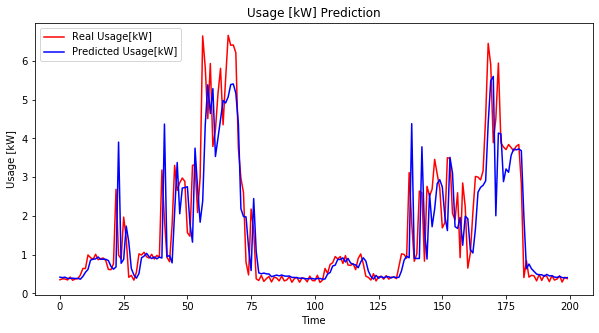

In [145]:
# 視覺化
plt.figure(figsize=(10,5))
plt.plot(X, color = 'red', label = 'Real Usage[kW]')  # 紅線表示Usage
plt.plot(X_predicted, color = 'blue', label = 'Predicted Usage[kW]')  # 藍線表示預測Usage
plt.title('Usage [kW] Prediction')
plt.xlabel('Time')
plt.ylabel('Usage [kW]')
plt.legend()
plt.show()


In [146]:
print('*Mean Absolute Error:', metrics.mean_absolute_error(X, X_predicted))  

*Mean Absolute Error: 0.5027950701622675
